# Import and setup

In [1]:
import torch
import torchvision
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import joblib

from functions import *
from sedct_explainer import *
from model_wrappers import *
from image_segmentations import *

# PYTORCH

In [2]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

mps


## Binary classification test


### Dataset

In [3]:
# Dataset for binary classification
dataset = tfds.load("cats_vs_dogs", as_supervised=True, split=['train[:80%]', 'train[80%:]'])

In [4]:
images_tensors = ConversionToTorchDataset(dataset[0].take(30))

img0 = images_tensors[0][0]

2025-06-04 14:47:34.285745: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-04 14:47:34.348172: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
type(img0)

torch.Tensor

In [6]:
plt.imshow(img0.permute(1,2,0))

### Classifier

In [7]:
class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = torch.nn.Sequential(
        self.make_block(3, 16),
        self.make_block(16, 32),
        self.make_block(32, 64),
        self.make_block(64, 128),
        self.make_block(128, 256),
        torch.nn.AdaptiveAvgPool2d(1)
    )

    # Linear + Sigmoid
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(256, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    features = torch.flatten(self.feature_extractor(x), 1)
    probs = self.classifier(features)
    return probs

  def make_block(self, in_channels, out_channels):
    # Conv -> Norm -> ReLU -> Conv -> Norm -> Relu
    block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,
                        out_channels,
                        kernel_size=3,
                        padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,
                        out_channels,
                        kernel_size=3,
                        padding=1,
                        stride=2), # works as maxpooling
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU()
    )
    return block

bin_classifier = Classifier()

In [ ]:
bin_classifier.load_state_dict(torch.load("Models/classifier.pt", map_location=DEVICE))

<All keys matched successfully>

In [9]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### SEDCT

In [11]:
explain = SEDCTExplainer()

In [12]:
model = TorchModelWrapper(bin_classifier, test_transform)

image = TorchImageSegmentation(img0, 'quickshift', 'fill', kernel_size=6, max_dist=15, ratio=0.2) 


In [13]:
image.image.shape

torch.Size([3, 262, 350])

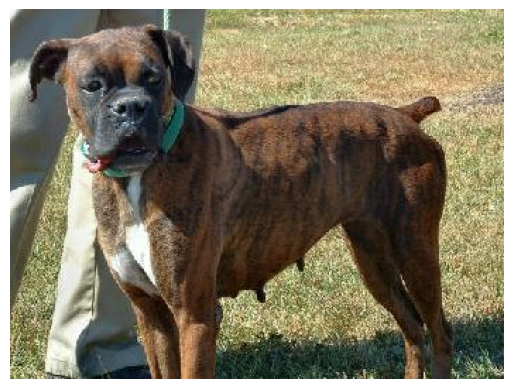

In [14]:
image.show_image()

In [15]:
image.options

{'kernel_size': 6, 'max_dist': 15, 'ratio': 0.2}

In [16]:
model._n_classes

1

In [17]:
model._output_is_logit

False

In [18]:
image.compute_segmentation()
segments = image.get_segments()
segments

array([[ 1,  1,  1, ...,  3,  3,  3],
       [ 1,  1,  1, ...,  3,  3,  3],
       [ 1,  1,  1, ...,  3,  3,  3],
       ...,
       [41, 41, 41, ..., 48, 48, 48],
       [41, 41, 41, ..., 48, 48, 48],
       [41, 41, 41, ..., 48, 48, 48]])

In [19]:
image._n_segments

56

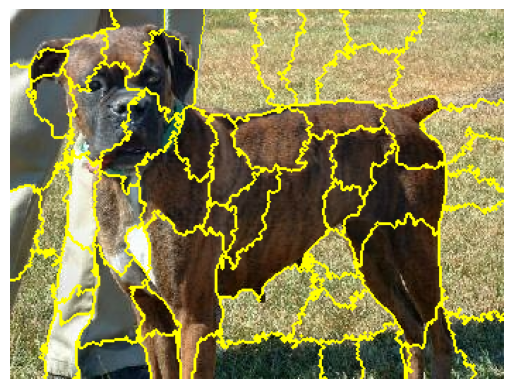

In [20]:
# img = image._tensor_to_ndarray(image.image)
# segmented_image = mark_boundaries(img, segments)
# plt.imshow(segmented_image)
image.show_segmented_image()

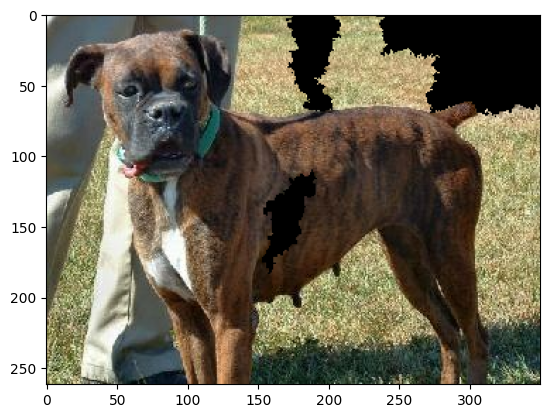

In [21]:
removed_image = image.remove_segment([3, 27,5,2], 'fill')
plt.imshow(removed_image.permute(1,2,0))

In [22]:
explain.explain_instance(model, image, max_iter=-1)

/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:460: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)


In [23]:
explain._counterfactual_id

[34, 36, 38, 6, 15, 17, 54]

In [24]:
counterfactual = explain.get_counterfactual()

counterfactual

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [25]:
explain.show_counterfactual()

## Multiclass Classification test

### Dataset

In [26]:
f_dataset = tfds.load("tf_flowers", as_supervised=True, split=['train[:80%]', 'train[80%:]'])

In [27]:
test_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Model

In [28]:
import torchvision.models as models

multi_classifier = models.resnet18(pretrained=True)

num_classes = 5
multi_classifier.fc = torch.nn.Linear(multi_classifier.fc.in_features, num_classes)

/Users/zenna/miniconda3/envs/sedct/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zenna/miniconda3/envs/sedct/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
multi_classifier.load_state_dict(torch.load("Models/multi_classifier.pt", map_location=DEVICE))

<All keys matched successfully>

### SEDCT

In [30]:
f_images = ConversionToTorchDataset(f_dataset[0].take(10))

f_image0 = f_images[0][0]

2025-06-04 14:47:41.251299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-04 14:47:41.253993: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# inizializing the objects
f_model = TorchModelWrapper(multi_classifier, test_transform2)

f_img = TorchImageSegmentation(f_image0, 'quickshift', 'fill', kernel_size=6, max_dist=30, ratio=0.3)


In [32]:
print(f_model._n_classes)
print(f_model._output_is_logit)

5
None


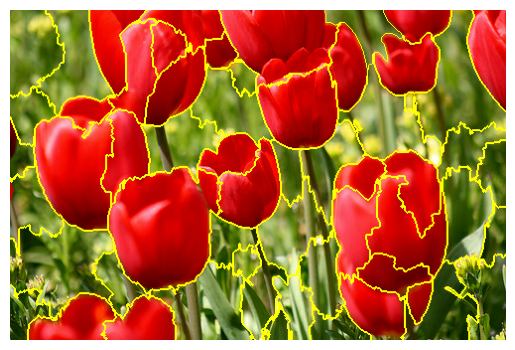

In [33]:
f_img.compute_segmentation()

f_img.show_segmented_image()

In [34]:
f_img.get_n_segments()

58

In [35]:
f_model.is_multiclass()

True

In [36]:
f_explain = SEDCTExplainer(f_model, f_img)

f_explain.explain_instance(target=0, max_iter=-1, show=True)

The algorithm has reached 'max_iter' value (58). No counterfactual has been found. To produce a counterfactual try to increse the 'max_iter' parameter.
The algorithm has not found any counterfactual. No image can be produced.


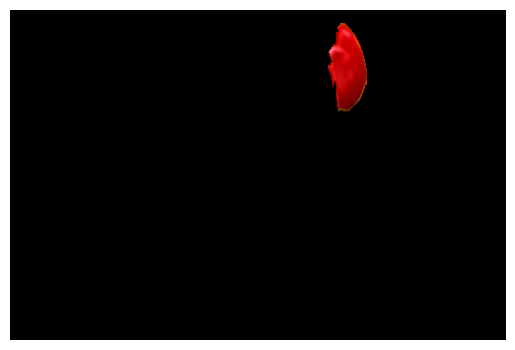

In [37]:
f_explain.explain_instance(target=2, max_iter=-1, show=True)

#### Another test

In [38]:
f_image1 = f_images[4][0]
f_img1 = TorchImageSegmentation(f_image1, 'quickshift', 'fill', kernel_size=6, max_dist=30, ratio=0.3)
f_explain1 = SEDCTExplainer(f_model, f_img1)

f_explain1.explain_instance(target=0, max_iter=-1)

In [39]:
f_explain1.show_counterfactual()

# SKLEARN


In [2]:
def load_tfds_data(dataset):
    ds = tfds.load(dataset, split='train', as_supervised=True)
    images, labels = [], []

    for img, label in tfds.as_numpy(ds):
        images.append(img)
        labels.append(label)
    
    X = np.array(images, dtype=object)
    y = np.array(labels)
    return X, y

## Binary Classification

### Image

In [3]:
# Dataset
X, y = load_tfds_data("cats_vs_dogs")

2025-06-04 16:03:05.912533: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-04 16:03:14.635054: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
IMG_SIZE = (64, 64)
img = X[0]

### Pipeline example

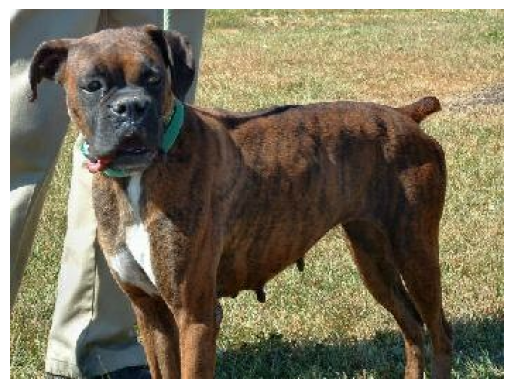

In [5]:
img1 = SKimageImageSegmentation(img, 'quickshift', 'fill', kernel_size=6, max_dist=15, ratio=0.2)

img1.show_image()

In [6]:
img1.compute_segmentation()
img1.show_segmented_image()

In [ ]:
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin

class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.reshape(X.shape[0], -1)

class ResizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=(64, 64)):
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        resized = np.array([
            tf.image.resize(img, self.size).numpy()
            for img in X
        ])
        return resized


pipeline = joblib.load("Models/pipeline_model.joblib")

In [8]:
model1 = SKLearnModelWrapper(pipeline)

/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning:

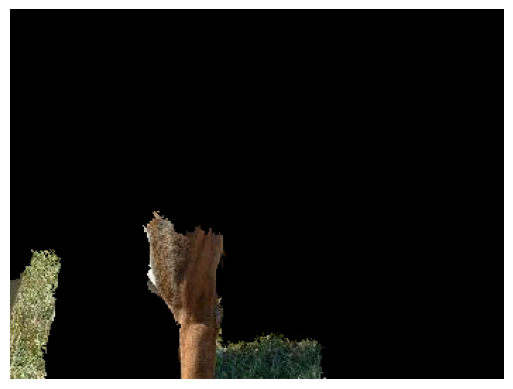

In [9]:
explainer = SEDCTExplainer(model1, img1)

explainer.explain_instance(max_iter=-1, show=True)

### Single classifier

In [ ]:
randomForest = joblib.load("Models/randomforest_model.joblib")

In [11]:
model2 = SKLearnModelWrapper(randomForest, resize_shape=IMG_SIZE, flatten=True)

In [12]:
def resize_batch(X, size):
    if isinstance(X, int):
        X = [X]
    return np.array([tf.image.resize(img, size).numpy() for img in X])

In [13]:
img_ = resize_batch(img.reshape(1, *img.shape), IMG_SIZE)

img2 = SKimageImageSegmentation(img_[0], 'quickshift', 'fill', kernel_size=6, max_dist=15, ratio=0.2)

In [14]:
# Flatten 
X = img_.reshape(len(img_), -1)

pred = randomForest.predict(X)
score = randomForest.predict_proba(X)

print(pred, score)

[1] [[0.15 0.85]]


In [15]:
X.shape

(1, 12288)

/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning:

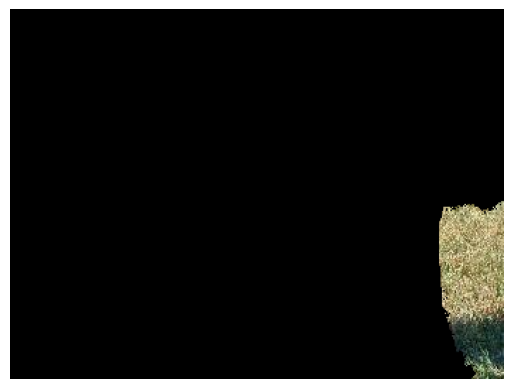

In [16]:
explainer2 = SEDCTExplainer(model2, img1)

explainer2.explain_instance(max_iter=-1, show=True)

### GridsearchCV 

In [ ]:
randomSearchCV = joblib.load("Models/randomSearch.joblib")
model3 = SKLearnModelWrapper(randomSearchCV, resize_shape=IMG_SIZE, flatten=True)

/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning:

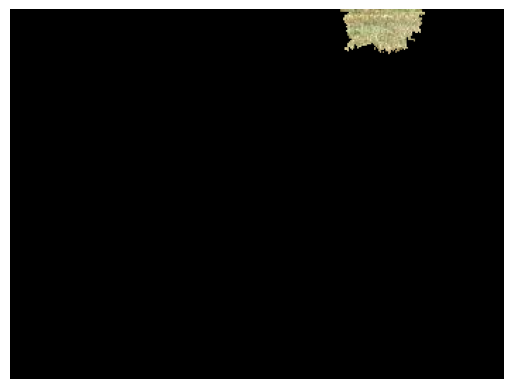

In [18]:
explainer3 = SEDCTExplainer(model3, img1)
explainer3.explain_instance(max_iter=-1, show=True)

## Multiclass 

In [19]:
IMG_SIZE = (64, 64)

X, y = load_tfds_data("tf_flowers")

2025-06-04 16:03:20.562394: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
f_img = X[0]

Text(0.5, 1.0, 'Label: 2')

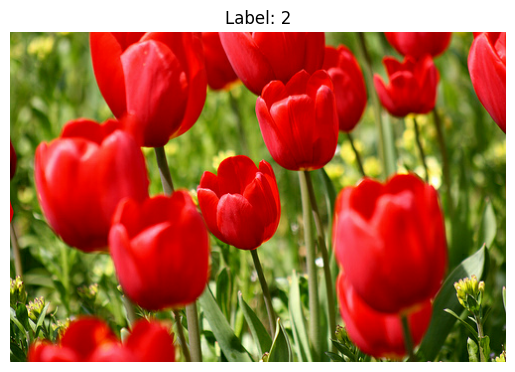

In [21]:
f_img1 = SKimageImageSegmentation(f_img, 'quickshift', 'fill', kernel_size=6, max_dist=15, ratio=0.2)

f_img1.show_image()
plt.title(f'Label: {y[0]}')

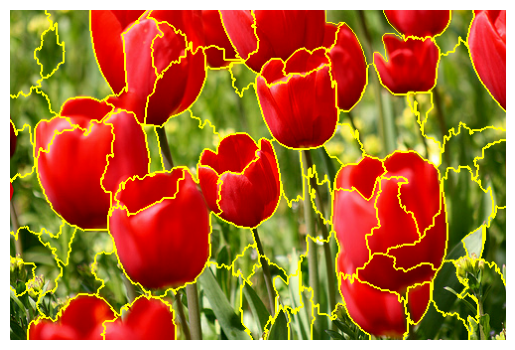

In [22]:
f_img1.compute_segmentation()
f_img1.show_segmented_image()

In [ ]:
class ResizeAndFlatten(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=IMG_SIZE):
        self.image_size = image_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed = []
        for img in X:
            img_resized = tf.image.resize(img, self.image_size).numpy().astype(np.float32)
            processed.append(img_resized.flatten())
        return np.stack(processed)


pipeline_multiclass = joblib.load("Models/pipeline_multiclass.joblib")

f_pipeline = SKLearnModelWrapper(pipeline_multiclass)

In [24]:
f_explainer1 = SEDCTExplainer(f_pipeline, f_img1)

f_explainer1.explain_instance(target=1, max_iter=-1, show=True)

/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning:

The algorithm has reached 'max_iter' value (76). No counterfactual has been found. To produce a counterfactual try to increse the 'max_iter' parameter.
The algorithm has not found any counterfactual. No image can be produced.


/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning: No method to fill the removed segment(s) was specified. 'fill' method as been used as default.
  warnings.warn("No method to fill the removed segment(s) was specified. 'fill' method as been used as default.", category=UserWarning)
/Users/zenna/uni/project_work/SEDCT/image_segmentations.py:558: UserWarning:

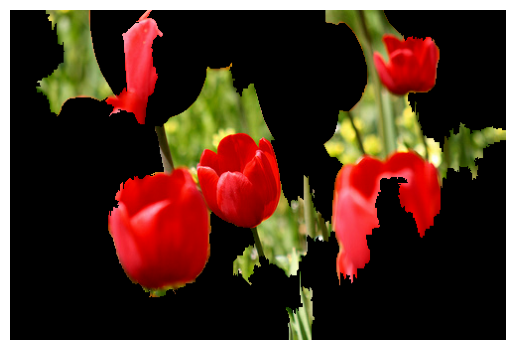

In [26]:
f_explainer1.explain_instance(target=3, max_iter=-1, show=True)